In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prince
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, roc_curve, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import seaborn as sns
from itertools import product
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean
import tensorflow as tf
import shap
%matplotlib inline
from xgboost import XGBClassifier

In [2]:
plt.style.use("seaborn")

## Import the data

In [3]:
IND_a= pd.read_csv("../Datasets/India_2021_access.csv")
IND_u= pd.read_csv('../Datasets/India_2021_usage.csv')
y= IND_a['fin34a'].copy()
w= IND_a['wgt'].copy()
IND_a= IND_a.drop(columns=['wgt','fin34a'])
IND_u= IND_u.drop(columns=['wgt','fin34a'])

In [4]:
y.value_counts()

0    2751
1     249
Name: fin34a, dtype: int64

In [5]:
sup= IND_a[IND_a.columns[:4]]
sup

,female,age,educ,inc_q
0,1,1.0,3,3
1,2,3.0,1,1
2,2,1.0,1,2
3,1,1.0,2,2
4,2,2.0,1,1
...,...,...,...,...
2995,2,6.0,1,1
2996,2,2.0,1,5
2997,2,1.0,2,2
2998,2,3.0,2,4


In [6]:
contingency_table = pd.crosstab(IND_a['educ'], IND_a['inc_q'])
contingency_table

inc_q,1,2,3,4,5
educ,,,,,
1,387,374,360,314,184
2,141,155,201,256,321
3,26,27,36,66,152


In [7]:
IND_a= IND_a.drop(columns= IND_a.columns[:4])
IND_u= IND_u.drop(columns= IND_u.columns[:4])

## Implementing MCA

In [8]:
mca_a = prince.MCA(n_components=9)

# Fit the MCA model to your data
mca_a.fit(IND_a)

# Transform the data into MCA coordinates
IND_a_index = mca_a.transform(IND_a)
new_column_names_a = {i: f'aPC{i+1}' for i in IND_a_index.columns}
IND_a_index = IND_a_index.rename(columns=new_column_names_a)
IND_a_index

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9
0,0.587078,0.247114,-0.076897,-0.137248,0.554451,-0.503335,0.441409,0.585057,-0.004684
1,-0.247635,-0.394006,0.133369,0.306026,-0.587427,0.007528,0.241312,-0.030502,-0.006984
2,-0.002833,-0.224659,-0.548914,0.100638,-0.023363,0.316391,-0.012364,0.218332,-0.006368
3,-0.064453,-0.365928,-0.147621,-0.220034,0.497055,0.127202,-0.059965,0.217315,-0.006855
4,-0.309254,-0.535274,0.534663,-0.014647,-0.067009,-0.181660,0.193711,-0.031519,-0.007470
...,...,...,...,...,...,...,...,...,...
2995,-0.058619,-0.357962,0.337537,-0.488520,-0.037246,0.123082,-0.016708,0.178179,-0.005937
2996,0.530772,-0.009763,-0.175443,-0.232263,0.530771,-0.241923,-0.189305,-0.447235,-0.011880
2997,-1.021621,0.749925,-0.129819,-0.356484,0.014529,0.227317,-0.345432,0.232202,-0.013083
2998,0.765801,0.526150,0.994553,0.048733,0.375061,0.788558,0.092838,-0.638683,-0.027411


In [9]:
mca_u = prince.MCA(n_components=32)

# Fit the MCA model to your data
mca_u.fit(IND_u)

# Transform the data into MCA coordinates
IND_u_index = mca_u.transform(IND_u)
new_column_names_u = {i: f'uPC{i+1}' for i in IND_u_index.columns}
IND_u_index = IND_u_index.rename(columns=new_column_names_u)
IND_u_index

,uPC1,uPC2,uPC3,uPC4,uPC5,uPC6,uPC7,uPC8,uPC9,uPC10,...,uPC23,uPC24,uPC25,uPC26,uPC27,uPC28,uPC29,uPC30,uPC31,uPC32
0,-0.046672,0.264536,-0.266671,0.038018,-0.220797,-0.047081,-0.004674,0.017591,0.027603,-0.005711,...,0.190728,-0.065567,0.053249,-0.266725,-0.032880,0.035695,0.049778,-0.006954,-0.018102,-0.001477
1,-0.101158,0.224009,-0.120430,-0.098499,-0.356877,0.175738,0.069578,-0.113805,-0.062947,0.136727,...,-0.219028,0.052666,0.088568,-0.036969,-0.034574,0.028459,0.046236,-0.008071,0.005166,-0.002529
2,-0.154232,0.461608,-0.051172,-0.193882,-0.120317,0.027873,-0.312519,-0.044010,-0.014584,0.028084,...,0.000979,-0.005222,0.024458,-0.005506,0.024107,-0.014030,-0.010087,-0.011215,-0.007483,-0.000113
3,-0.279200,-0.173484,0.068897,0.005046,-0.062503,-0.149567,0.006101,-0.156495,0.018142,-0.085726,...,0.002472,-0.031500,0.031643,-0.023328,0.034604,-0.020330,0.015728,-0.004683,-0.009356,0.002490
4,-0.032942,0.432370,-0.048018,0.164407,0.022539,-0.074023,0.219267,0.112454,0.062480,-0.042630,...,-0.062338,-0.041273,0.066737,-0.029005,-0.050088,-0.092376,-0.035031,0.040368,0.027869,0.006911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.209947,-0.099606,0.292744,-0.389641,0.020997,0.161393,0.234038,0.407240,-0.051527,-0.198851,...,-0.078622,-0.390665,-0.192429,-0.310268,-0.126157,-0.048630,-0.012063,-0.008091,-0.027820,0.008857
2996,-0.027924,0.311863,-0.065682,-0.054516,-0.067124,-0.170297,-0.168994,-0.054999,-0.064163,0.067920,...,0.039565,0.032087,-0.131152,0.075628,-0.039465,0.046095,0.060724,-0.004067,-0.000154,-0.013822
2997,-0.348606,-0.287903,-0.288812,0.102424,0.175788,0.128221,0.097197,-0.034477,-0.015424,-0.014669,...,0.000895,0.007245,-0.007568,0.014272,-0.004670,-0.008404,0.011297,-0.006849,-0.000676,-0.003597
2998,0.214804,0.227556,-0.173810,-0.264865,-0.232104,-0.149598,0.304606,0.560685,0.984393,0.275319,...,0.277415,0.004747,-0.040347,-0.037133,-0.007027,0.016297,0.021333,-0.020853,-0.003326,-0.016856


In [10]:
X = pd.concat([IND_a_index, IND_u_index, sup], axis=1)
X

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9,uPC1,...,uPC27,uPC28,uPC29,uPC30,uPC31,uPC32,female,age,educ,inc_q
0,0.587078,0.247114,-0.076897,-0.137248,0.554451,-0.503335,0.441409,0.585057,-0.004684,-0.046672,...,-0.032880,0.035695,0.049778,-0.006954,-0.018102,-0.001477,1,1.0,3,3
1,-0.247635,-0.394006,0.133369,0.306026,-0.587427,0.007528,0.241312,-0.030502,-0.006984,-0.101158,...,-0.034574,0.028459,0.046236,-0.008071,0.005166,-0.002529,2,3.0,1,1
2,-0.002833,-0.224659,-0.548914,0.100638,-0.023363,0.316391,-0.012364,0.218332,-0.006368,-0.154232,...,0.024107,-0.014030,-0.010087,-0.011215,-0.007483,-0.000113,2,1.0,1,2
3,-0.064453,-0.365928,-0.147621,-0.220034,0.497055,0.127202,-0.059965,0.217315,-0.006855,-0.279200,...,0.034604,-0.020330,0.015728,-0.004683,-0.009356,0.002490,1,1.0,2,2
4,-0.309254,-0.535274,0.534663,-0.014647,-0.067009,-0.181660,0.193711,-0.031519,-0.007470,-0.032942,...,-0.050088,-0.092376,-0.035031,0.040368,0.027869,0.006911,2,2.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-0.058619,-0.357962,0.337537,-0.488520,-0.037246,0.123082,-0.016708,0.178179,-0.005937,0.209947,...,-0.126157,-0.048630,-0.012063,-0.008091,-0.027820,0.008857,2,6.0,1,1
2996,0.530772,-0.009763,-0.175443,-0.232263,0.530771,-0.241923,-0.189305,-0.447235,-0.011880,-0.027924,...,-0.039465,0.046095,0.060724,-0.004067,-0.000154,-0.013822,2,2.0,1,5
2997,-1.021621,0.749925,-0.129819,-0.356484,0.014529,0.227317,-0.345432,0.232202,-0.013083,-0.348606,...,-0.004670,-0.008404,0.011297,-0.006849,-0.000676,-0.003597,2,1.0,2,2
2998,0.765801,0.526150,0.994553,0.048733,0.375061,0.788558,0.092838,-0.638683,-0.027411,0.214804,...,-0.007027,0.016297,0.021333,-0.020853,-0.003326,-0.016856,2,3.0,2,4


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

## Logistic regression

In [12]:
lr = LogisticRegression(solver='newton-cg', max_iter=200)

#Setting the range for class weights
weights= [i for i in np.linspace(0, 10, 200)]
weights= list(product(weights, weights))

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0: 2.61, 1:9.20}], 
              'C': [i for i in range(9,10)]}

#Fitting grid search to the train data with 5 folds
grid_search_lr = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [13]:
print('Best parameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)

Best parameters: {'C': 9, 'class_weight': {0: 2.61, 1: 9.2}}
Best score: 0.7986492431633747


In [14]:
best_lr = LogisticRegression(**grid_search_lr.best_params_)
best_lr.fit(X_train, y_train)

proba = best_lr.predict_proba(X_test)
y_= proba[:,1]

auc1 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc1)

# Calculate precision, recall, and F1-score
target_names = ["0", "1"]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9860352155434123
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       549
           1       0.78      0.96      0.86        51

    accuracy                           0.97       600
   macro avg       0.89      0.97      0.92       600
weighted avg       0.98      0.97      0.97       600



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


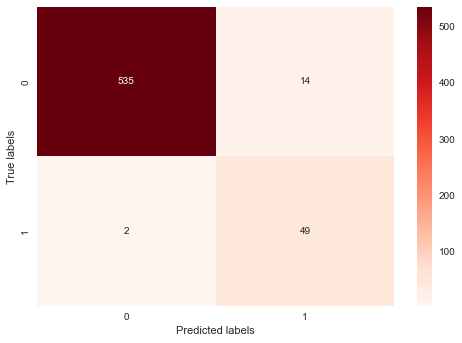

In [15]:
cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [16]:
acc_1= accuracy_score(y_test, y_pred)
pre_1= precision_score(y_test, y_pred)
rec_1= recall_score(y_test, y_pred)
f_1_1= f1_score(y_test, y_pred)

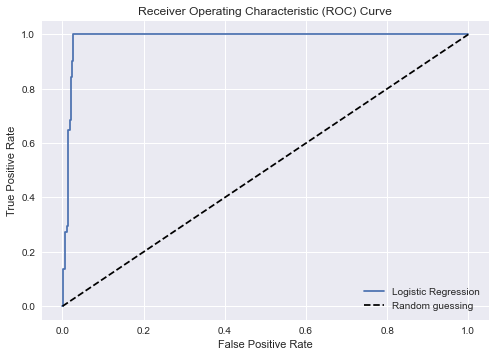

In [17]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Random Forest

In [18]:
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))
param_grid = {
    'n_estimators': [i for i in range(97,98)],
    'max_depth': [i for i in range(7,8)],
    'min_samples_split': [i for i in range(2,3)],
    'min_samples_leaf': [i for i in range(2,3)],
    'max_features': ['sqrt'],
    'class_weight': [{0: .01, 1: .18}]
}
rf = RandomForestClassifier(random_state= 42)

In [19]:
grid_search_rf = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
proba= best_rf.predict_proba(X_test)
y_=proba[:,1]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)
print(f'Best hyperparameters: {grid_search_rf.best_params_}')
print('Best score:', grid_search_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'class_weight': {0: 0.01, 1: 0.18}, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 97}
Best score: 0.6812370670809871


In [20]:
auc2 = roc_auc_score(y_test, proba[:,1], multi_class='auto')
print('AUC:', auc2)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9761777206328797
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       549
           1       0.66      0.78      0.71        51

    accuracy                           0.95       600
   macro avg       0.82      0.87      0.84       600
weighted avg       0.95      0.95      0.95       600



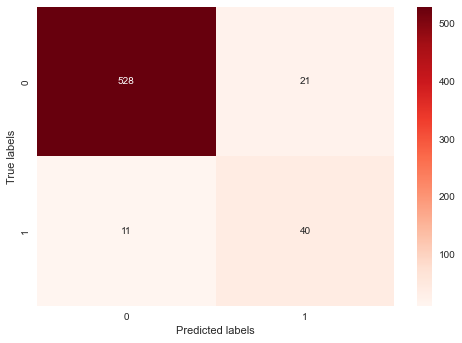

In [21]:
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [22]:
acc_2= accuracy_score(y_test, y_pred)
pre_2= precision_score(y_test, y_pred)
rec_2= recall_score(y_test, y_pred)
f_1_2= f1_score(y_test, y_pred)

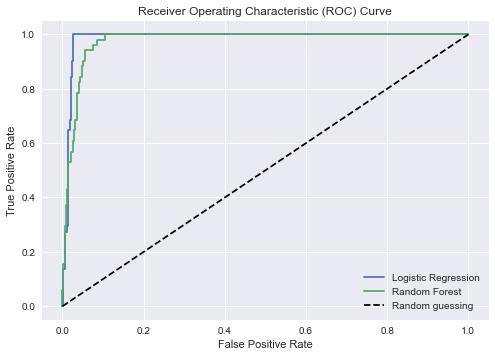

In [23]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## XG Boost

In [24]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos

In [25]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [10],
    'learning_rate': [.1],
    'n_estimators': [376],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'reg_alpha': [0.5],
    'reg_lambda': [0.1],
}
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
print("Best hyperparameters: ", grid_search_xgb.best_params_)
print("Best F1 score: ", grid_search_xgb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 376, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
Best F1 score:  0.7159714291204462


In [26]:
best_xgb = XGBClassifier(**grid_search_xgb.best_params_)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
proba = best_xgb.predict_proba(X_test)
y_= proba[:,1]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)

In [27]:
auc3 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc3)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9788921032894031
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       549
           1       0.78      0.55      0.64        51

    accuracy                           0.95       600
   macro avg       0.87      0.77      0.81       600
weighted avg       0.94      0.95      0.94       600



In [28]:
acc_3= accuracy_score(y_test, y_pred)
pre_3= precision_score(y_test, y_pred)
rec_3= recall_score(y_test, y_pred)
f_1_3= f1_score(y_test, y_pred)

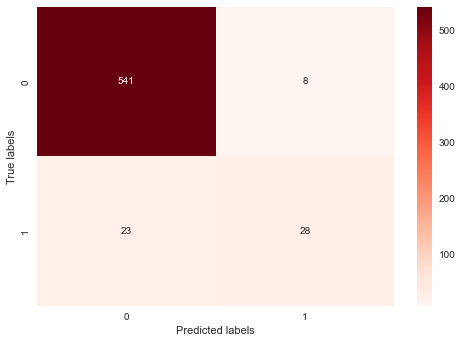

In [29]:
cm3 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm3, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

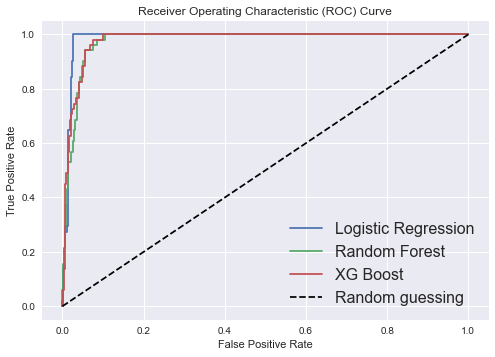

In [30]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='XG Boost')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(fontsize=16)
plt.show()

## Artificial Neural Network

In [31]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [33]:
history = ann.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
60/60 [==============================] - 2s 10ms/step - loss: 0.2844 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.2019 - precision: 1.0000 - recall: 0.0850 - val_loss: 0.2241 - val_precision: 0.8000 - val_recall: 0.0889
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.1525 - precision: 0.8730 - recall: 0.3595 - val_loss: 0.1758 - val_precision: 0.6923 - val_recall: 0.4000
Epoch 4/50
60/60 [==============================] - 0s 4ms/step - loss: 0.1217 - precision: 0.7959 - recall: 0.5098 - val_loss: 0.1582 - val_precision: 0.8667 - val_recall: 0.2889
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.1009 - precision: 0.8037 - recall: 0.5621 - val_loss: 0.1284 - val_precision: 0.8065 - val_recall: 0.5556
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0886 - pr

60/60 [==============================] - 0s 2ms/step - loss: 0.0059 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2266 - val_precision: 0.8000 - val_recall: 0.6222
Epoch 47/50
60/60 [==============================] - 0s 2ms/step - loss: 0.0053 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2195 - val_precision: 0.7750 - val_recall: 0.6889
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0049 - precision: 0.9935 - recall: 1.0000 - val_loss: 0.2420 - val_precision: 0.7714 - val_recall: 0.6000
Epoch 49/50
60/60 [==============================] - 0s 2ms/step - loss: 0.0041 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2487 - val_precision: 0.7714 - val_recall: 0.6000
Epoch 50/50
60/60 [==============================] - 0s 2ms/step - loss: 0.0040 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2527 - val_precision: 0.7778 - val_recall: 0.6222


In [34]:
y_ = ann.predict(X_test)

19/19 [==============================] - 0s 1ms/step


In [35]:
y_= y_.reshape(y_.shape[0],)

In [36]:
y_pred= np.array([round(i) for i in y_])

In [37]:
auc4 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc4)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9840708596735598
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       549
           1       0.80      0.63      0.70        51

    accuracy                           0.95       600
   macro avg       0.88      0.81      0.84       600
weighted avg       0.95      0.95      0.95       600



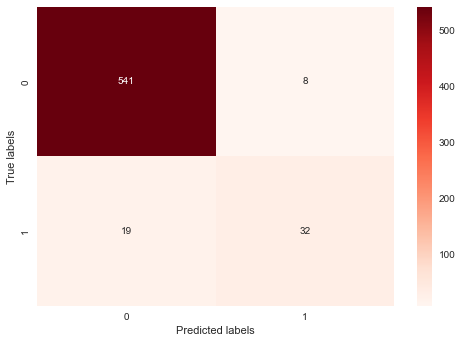

In [38]:
cm4 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm4, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [39]:
acc_4= accuracy_score(y_test, y_pred)
pre_4= precision_score(y_test, y_pred)
rec_4= recall_score(y_test, y_pred)
f_1_4= f1_score(y_test, y_pred)

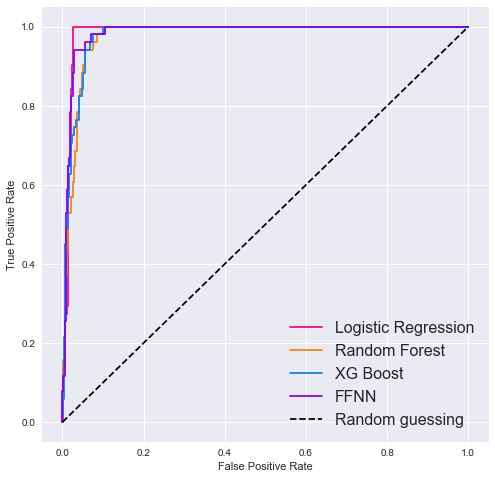

In [40]:
fpr4, tpr4, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1, label='Logistic Regression', color= "#ff007f")
plt.plot(fpr2, tpr2, label='Random Forest', color= "#ff7f00")
plt.plot(fpr3, tpr3, label='XG Boost', color= "#007fff")
plt.plot(fpr4, tpr4, label='FFNN', color= "#7f00ff")
plt.plot([0, 1], [0, 1], linestyle='--', color= "#000000", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(fontsize=16)
plt.savefig("../../images/roc_ind.png")
plt.show()

## Model Evaluations

In [41]:
data= {"Metrics":["Accuracy", "Recall", "Precision", "F1-Score", "AUC"],
       "LR":[round(acc_1,4), round(rec_1,4), round(pre_1,4), round(f_1_1,4), round(auc1,4)], 
       "RF":[round(acc_2,4), round(rec_2,4), round(pre_2,4), round(f_1_2,4), round(auc2,4)], 
       "XGB":[round(acc_3,4), round(rec_3,4), round(pre_3,4), round(f_1_3,4), round(auc3,4)], 
       "FFNN":[round(acc_4,4), round(rec_4,4), round(pre_4,4), round(f_1_4,4), round(auc4,4)]}
df = pd.DataFrame(data)
latex_code = df.to_latex(index=False)

# Print the LaTeX code
print(latex_code)

\begin{tabular}{lrrrr}
\toprule
  Metrics &     LR &     RF &    XGB &   FFNN \\
\midrule
 Accuracy & 0.9733 & 0.9467 & 0.9483 & 0.9550 \\
   Recall & 0.9608 & 0.7843 & 0.5490 & 0.6275 \\
Precision & 0.7778 & 0.6557 & 0.7778 & 0.8000 \\
 F1-Score & 0.8596 & 0.7143 & 0.6437 & 0.7033 \\
      AUC & 0.9860 & 0.9762 & 0.9789 & 0.9841 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Build the index

In [42]:
eig_a= mca_a.eigenvalues_
IND_a_index["access"]= sum([IND_a_index[IND_a_index.columns[i]]*eig_a[i] for i in range(len(eig_a))])
eig_u= mca_u.eigenvalues_
IND_u_index["usage"]= sum([IND_u_index[IND_u_index.columns[i]]*eig_u[i] for i in range(len(eig_u)) ])

In [43]:
IND_fin= pd.concat([IND_a_index["access"], IND_u_index["usage"], sup, y], axis=1)

In [44]:
IND_fin["access"]= IND_fin["access"]*w
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(-0.9674836357816766, 2.9041560508835205, -0.04472472110340059)

In [45]:
IND_fin["access"] -= min(IND_fin["access"])
IND_fin["access"] /= max(IND_fin["access"])

In [46]:
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(0.0, 1.0, 0.23833801421564782)

In [47]:
IND_fin["usage"]= IND_fin["usage"]*w
min(IND_fin["usage"]), max(IND_fin["usage"]), mean(IND_fin["usage"])

(-0.22421892477706984, 1.0741852456439478, -0.005908688565066075)

In [48]:
IND_fin["usage"] -= min(IND_fin["usage"])
IND_fin["usage"] /= max(IND_fin["usage"])

In [49]:
#IND_fin["access"] = 1- IND_fin["access"]
#IND_fin["usage"] = 1- IND_fin["usage"]

In [50]:
IND_fin["index"]= (IND_fin['access'] + IND_fin['usage'])/2

In [51]:
fin_0= IND_fin[IND_fin["fin34a"]==0].copy()
fin_1= IND_fin[IND_fin["fin34a"]==1].copy()

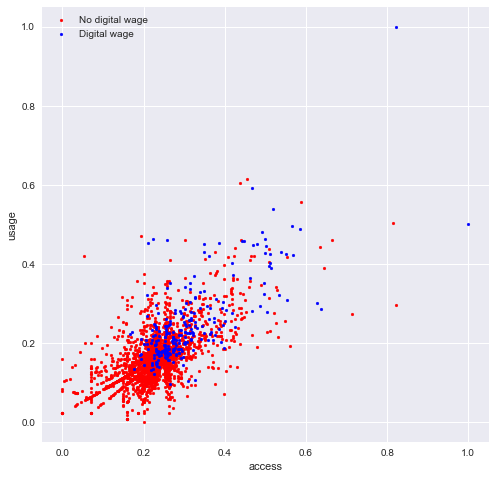

In [52]:
plt.figure(figsize=(8,8))
plt.scatter(fin_0["access"], fin_0["usage"], label= "No digital wage", s=32, color="#ff0000",
            marker='.')
plt.scatter(fin_1["access"], fin_1["usage"], label= "Digital wage", s=32, color="#0000ff",
            marker='.')
plt.xlabel("access")
plt.ylabel("usage")
plt.legend()
#plt.ylim([-0.05,0.55])
#plt.xlim([-0.05,.65])
plt.savefig('../../images/find_ind')
plt.show()

In [53]:
IND_fin['access'].describe()

count    3000.000000
mean        0.238338
std         0.077684
min         0.000000
25%         0.206967
50%         0.234728
75%         0.258010
max         1.000000
Name: access, dtype: float64

In [54]:
IND_fin['usage'].describe()

count    3000.000000
mean        0.168137
std         0.070169
min         0.000000
25%         0.129658
50%         0.159050
75%         0.191283
max         1.000000
Name: usage, dtype: float64

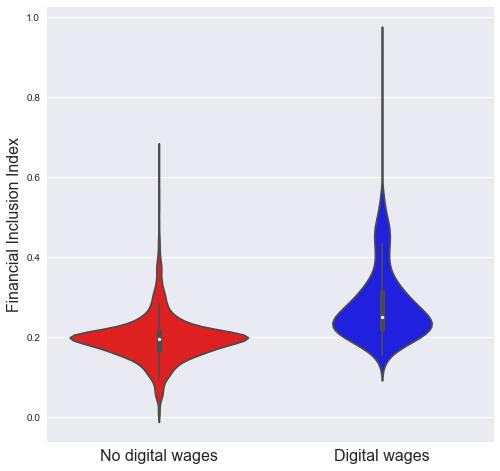

In [55]:
colors = ["#ff0000", "#0000ff"]
plt.figure(figsize=(8, 8))
sns.violinplot(x='fin34a', y='index', data=IND_fin, palette= colors)
custom_category_names = ['No digital wages', 'Digital wages']
plt.xticks(range(len(custom_category_names)), custom_category_names, fontsize=16)
plt.xlabel('')
plt.ylabel('Financial Inclusion Index', fontsize=16)

plt.savefig('../../images/ind_ind')

# Show the plot
plt.show()

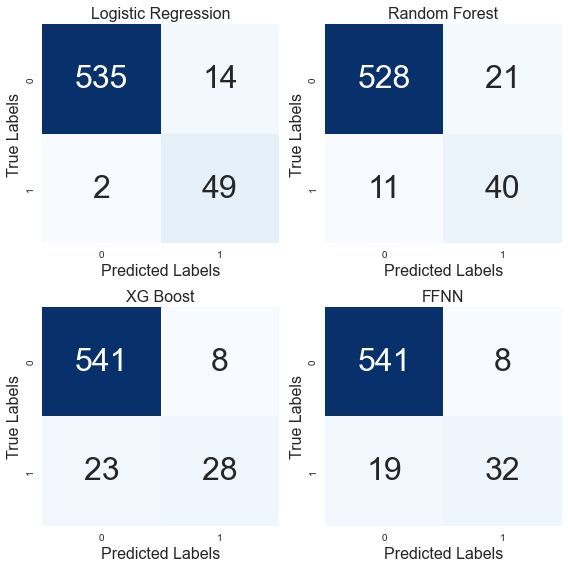

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
cm= [cm1, cm2, cm3, cm4]
mods= ["Logistic Regression", "Random Forest", "XG Boost", "FFNN"]
# Compute and plot confusion matrices
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(cm[i], annot=True, cmap="Blues", fmt='d', ax=ax, cbar=False, 
                annot_kws={"fontsize": 32})
    ax.set_title(f"{mods[i]}", fontsize=16)
    ax.set_xlabel("Predicted Labels", fontsize=16)
    ax.set_ylabel("True Labels", fontsize=16)

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('../../images/comat_ind.png')
# Display the plot
plt.show()

## Feature Importance

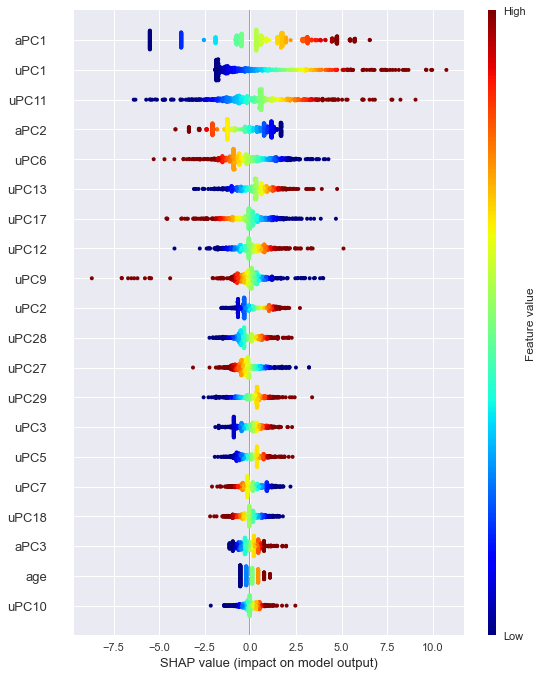

In [65]:
explainer = shap.Explainer(best_lr, X_train)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.

shap.summary_plot(shap_values, X_test, cmap= "jet")

In [58]:
u= mca_u.column_contributions_
u= u.rename(columns=new_column_names_u)
a= mca_a.column_contributions_
a= a.rename(columns=new_column_names_a)

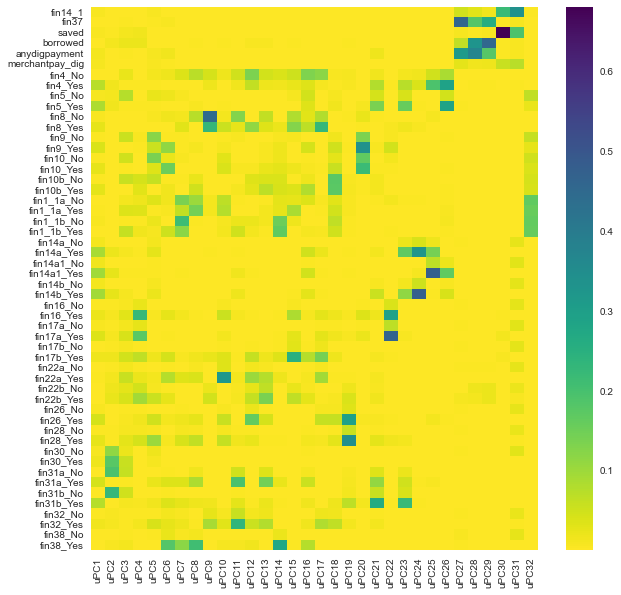

In [59]:
plt.figure(figsize=(10,10))
sns.heatmap(u, annot=False, cmap="viridis_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/us_ind.png')
plt.show()

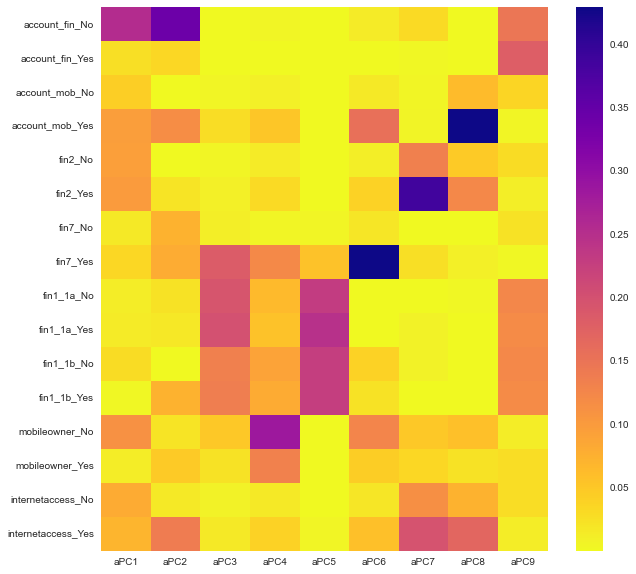

In [60]:
plt.figure(figsize=(10,10))
sns.heatmap(a, annot=False, cmap="plasma_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/acc_ind.png')
plt.show()

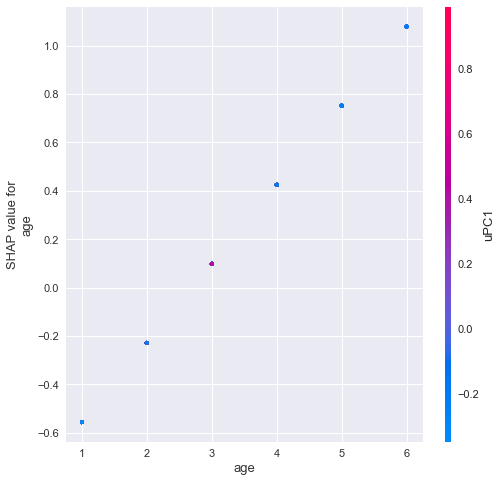

In [61]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('age', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

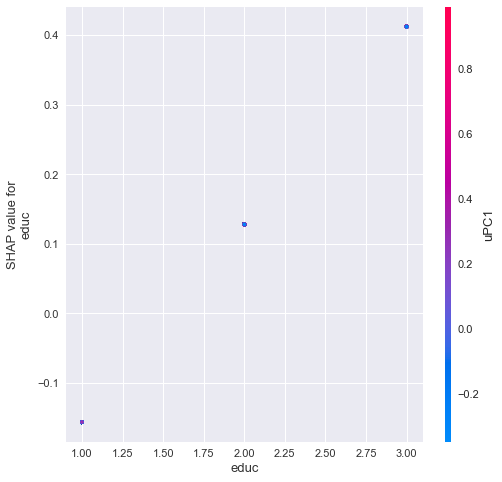

In [62]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('educ', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

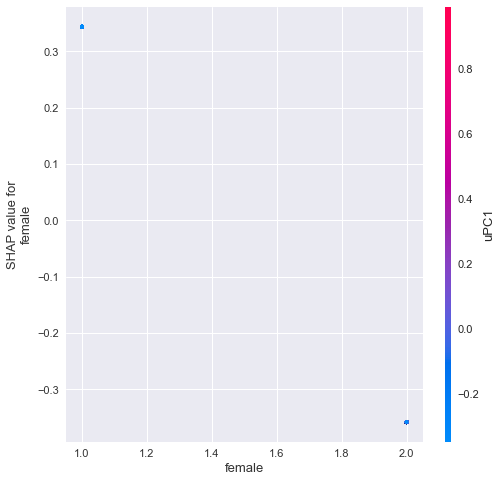

In [63]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('female', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

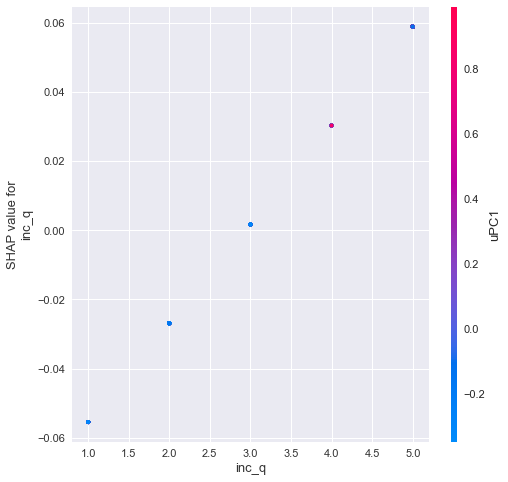

In [64]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('inc_q', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()